In [1]:
import os
import pandas as pd 
import numpy 
import matplotlib.pyplot as plt
import seaborn as sns
import pltfont

In [2]:
pltfont.auto()

✅ 현재 폰트 적용됨: Arial Unicode MS


In [3]:
list1 = pltfont.list_fonts()

1. Arial Unicode MS
2. DungGeunMo
3. Intel One Mono


In [4]:
data_path = "/Users/jun/GitStudy/commerceAB/data/thelook_ecommerce"
data_list = os.listdir(data_path)
data_list.sort()
data_list

['distribution_centers_gzip.parquet',
 'inventory_items_gzip.parquet',
 'order_items_gzip.parquet',
 'orders_gzip.parquet',
 'products_gzip.parquet',
 'users_gzip.parquet']

In [5]:
cols = [i.rstrip("_gzip.parquet") for i in data_list ]

cols

['distribution_centers',
 'inventory_items',
 'order_items',
 'orders',
 'products',
 'users']

In [6]:
users_file_path = data_path + "/users_gzip.parquet"
users_df = pd.read_parquet(users_file_path, engine='pyarrow')  # 또는 engine='fastparquet'

In [7]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   id              100000 non-null  Int64              
 1   age             100000 non-null  Int64              
 2   gender          100000 non-null  object             
 3   state           100000 non-null  object             
 4   city            100000 non-null  object             
 5   created_at      100000 non-null  datetime64[ns, UTC]
 6   traffic_source  100000 non-null  object             
dtypes: Int64(2), datetime64[ns, UTC](1), object(4)
memory usage: 5.5+ MB


In [8]:
users_df.describe(include='all',datetime_is_numeric=True)

,id,age,gender,state,city,created_at,traffic_source
count,100000.0,100000.0,100000,100000,100000,100000,100000
unique,<NA>,<NA>,2,229,7861,NaN,5
top,<NA>,<NA>,F,Guangdong,Shanghai,NaN,Search
freq,<NA>,<NA>,50142,5282,2498,NaN,70086
mean,50000.5,41.0062,NaN,NaN,NaN,2022-06-18 18:28:22.912000768+00:00,NaN
min,1.0,12.0,NaN,NaN,NaN,2019-01-02 01:00:00+00:00,NaN
25%,25000.75,26.0,NaN,NaN,NaN,2020-09-22 04:19:30+00:00,NaN
50%,50000.5,41.0,NaN,NaN,NaN,2022-06-19 04:15:00+00:00,NaN
75%,75000.25,56.0,NaN,NaN,NaN,2024-03-14 09:05:15+00:00,NaN
max,100000.0,70.0,NaN,NaN,NaN,2025-10-07 19:32:25.712857+00:00,NaN


In [9]:
users_df.isnull().sum()

id                0
age               0
gender            0
state             0
city              0
created_at        0
traffic_source    0
dtype: int64

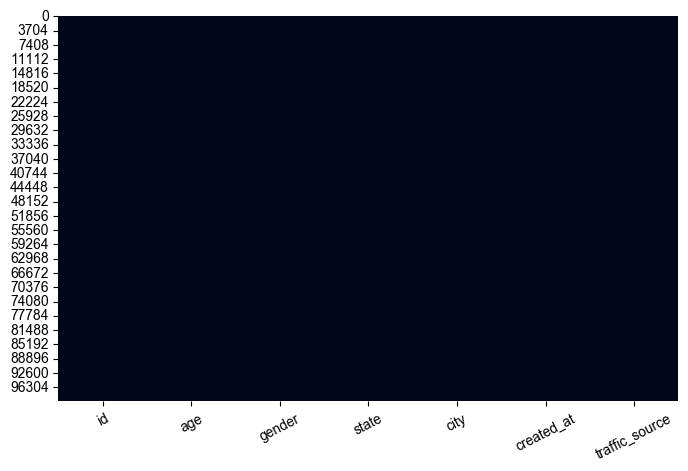

In [10]:
plt.figure(figsize=(8,5))  # 전체 그림 크기 지정
sns.heatmap(users_df.isnull(), cbar=False)
plt.xticks(rotation=27)  # x축 라벨 기울이기
plt.show()

In [49]:
users_df['date'] = pd.to_datetime(users_df['created_at'].dt.date)


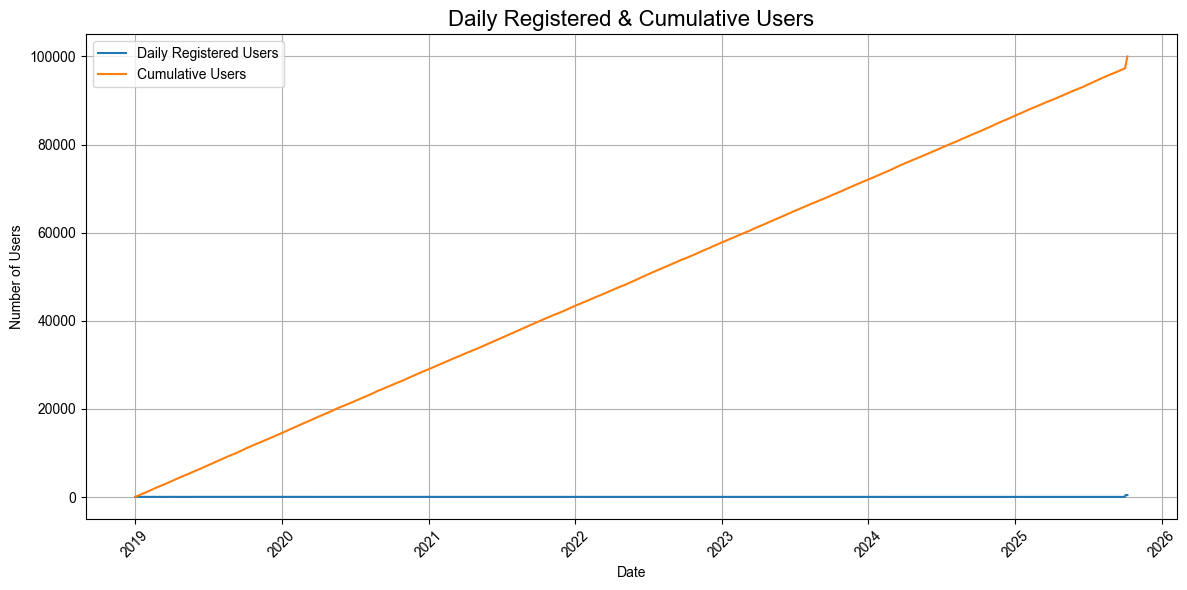

In [50]:
# 그룹핑 후 reset_index()로 인덱스를 컬럼으로 변환
daily_users_Registered = users_df.groupby(users_df['date']).agg({"id":"count"}).reset_index()
daily_users_Registered.rename(columns={"id":"user_cnt"}, inplace=True)

# 누적 사용자 수 계산
daily_users_Registered["cumulative"] = daily_users_Registered["user_cnt"].cumsum()

# plot
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_users_Registered, x="date", y="user_cnt", label="Daily Registered Users")
sns.lineplot(data=daily_users_Registered, x="date", y="cumulative", label="Cumulative Users")

plt.title("Daily Registered & Cumulative Users", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


<Axes: xlabel='date', ylabel='user_cnt'>

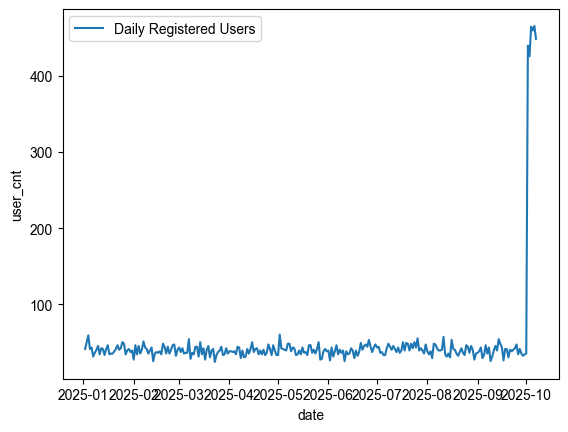

In [53]:
# 문자열 → pandas Timestamp
filtered_df = daily_users_Registered[daily_users_Registered['date'] > pd.to_datetime("2025-01-01")]
# plot
sns.lineplot(data=filtered_df, x="date", y="user_cnt", label="Daily Registered Users")


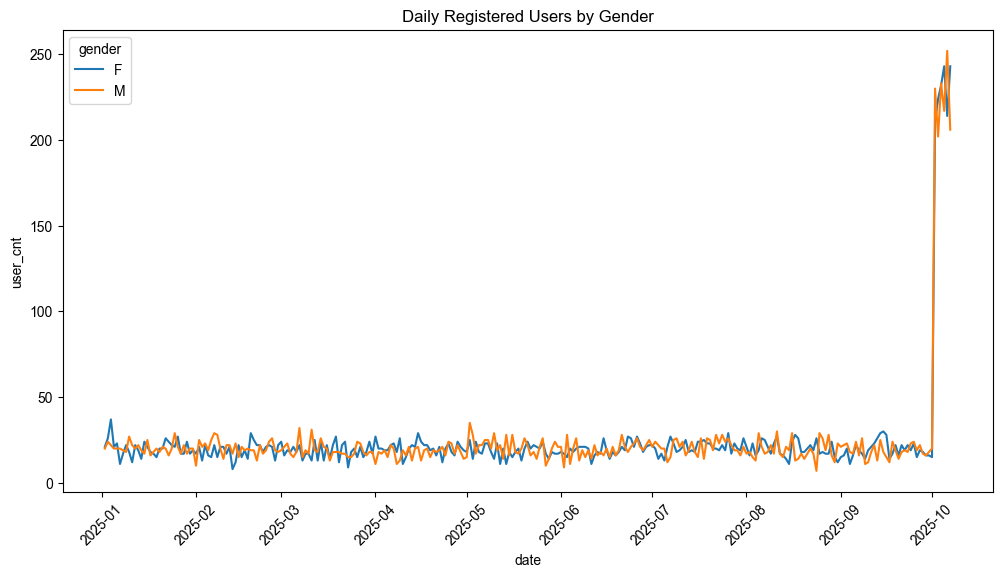

In [54]:
# 성별 기준, 날짜별 집계
daily_gender_users = (
    users_df[users_df['date'] > "2025-01-01"]
    .groupby([users_df['date'], 'gender'])
    .agg(user_cnt=('id','count'))
    .reset_index()
)

# plot
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_gender_users, x='date', y='user_cnt', hue='gender')
plt.xticks(rotation=45)
plt.title("Daily Registered Users by Gender")
plt.show()

/var/folders/29/5wmqbm4j3x10qv5vgm_bm8f80000gn/T/ipykernel_22706/3783721009.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette="pastel")


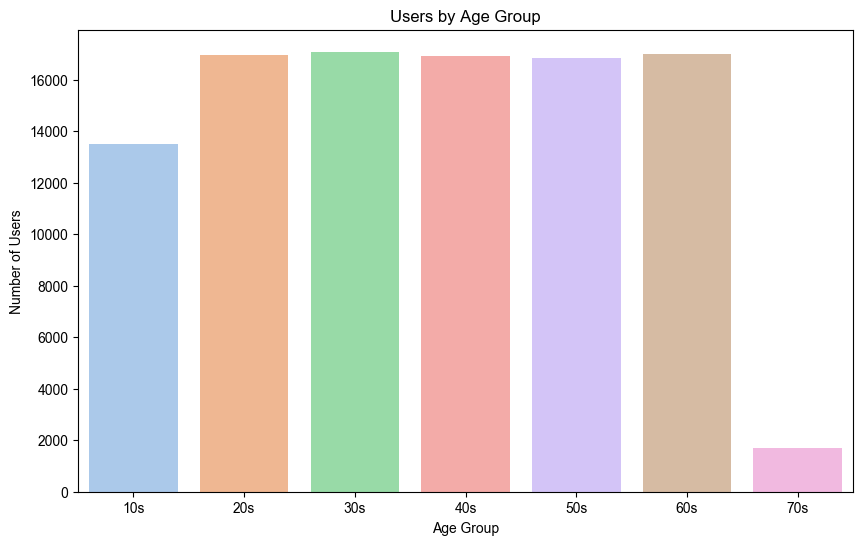

In [55]:
# 10세 단위 연령대 생성
bins = [10,20,30,40,50,60,70,80]
labels = ["10s","20s","30s","40s","50s","60s","70s"]
users_df['age_group'] = pd.cut(users_df['age'], bins=bins, labels=labels, right=False)

# 연령대별 사용자 수 집계
age_group_counts = users_df['age_group'].value_counts().sort_index()

# plot
plt.figure(figsize=(10,6))
sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette="pastel")
plt.title("Users by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Users")
plt.show()

/var/folders/29/5wmqbm4j3x10qv5vgm_bm8f80000gn/T/ipykernel_22706/1387218440.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette="pastel")


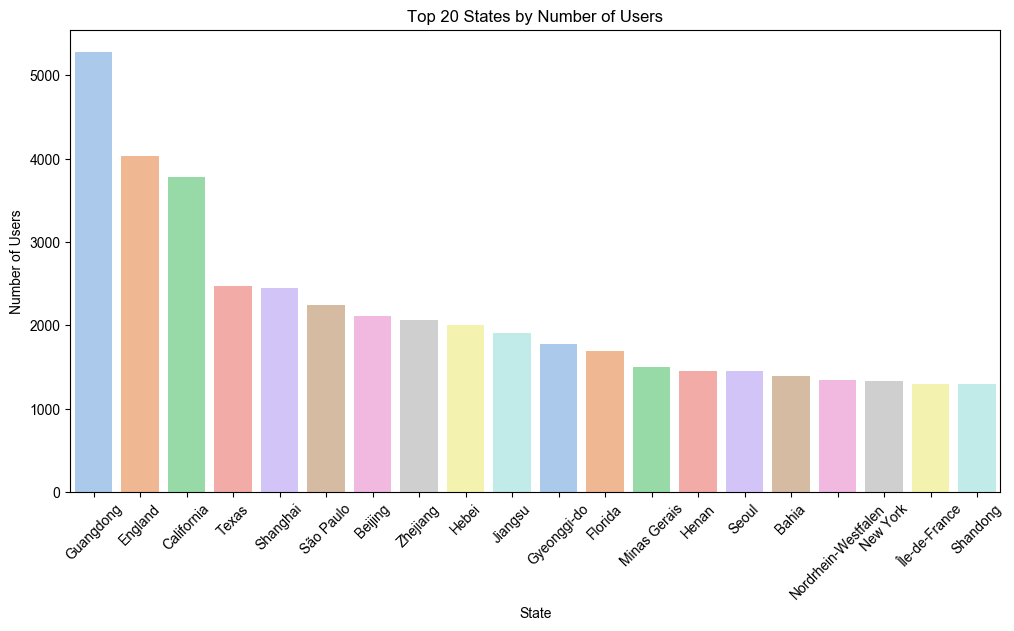

In [56]:
state_counts = users_df['state'].value_counts().head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette="pastel")
plt.xticks(rotation=45)
plt.title("Top 20 States by Number of Users")
plt.xlabel("State")
plt.ylabel("Number of Users")
plt.show()

/var/folders/29/5wmqbm4j3x10qv5vgm_bm8f80000gn/T/ipykernel_22706/2614956814.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.index, y=top_cities.values, palette="muted")


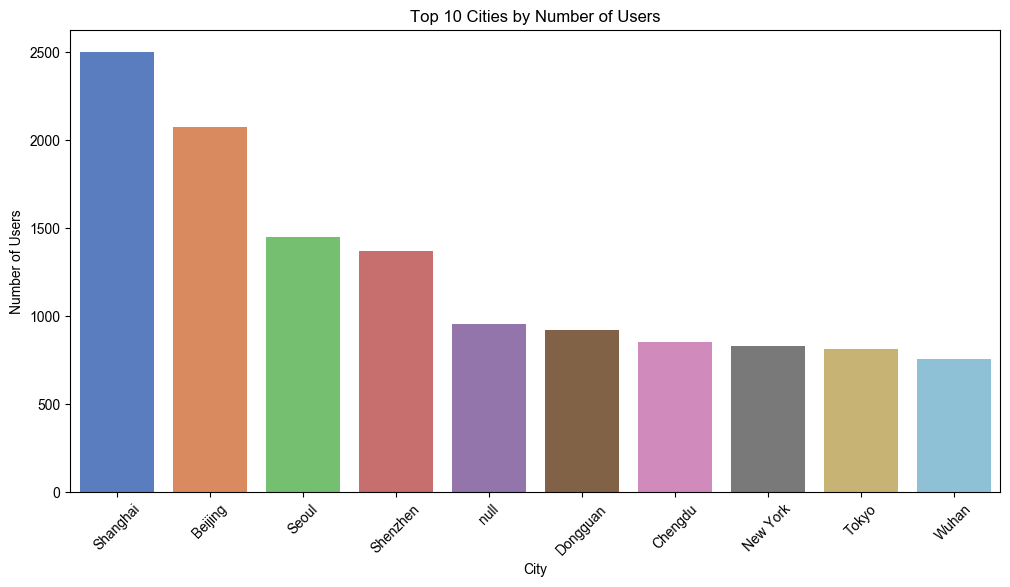

In [57]:
## not null 했는데도, null 보임.
top_cities = users_df[users_df['city'].notnull()]['city'].value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_cities.index, y=top_cities.values, palette="muted")
plt.xticks(rotation=45)
plt.title("Top 10 Cities by Number of Users")
plt.xlabel("City")
plt.ylabel("Number of Users")
plt.show()

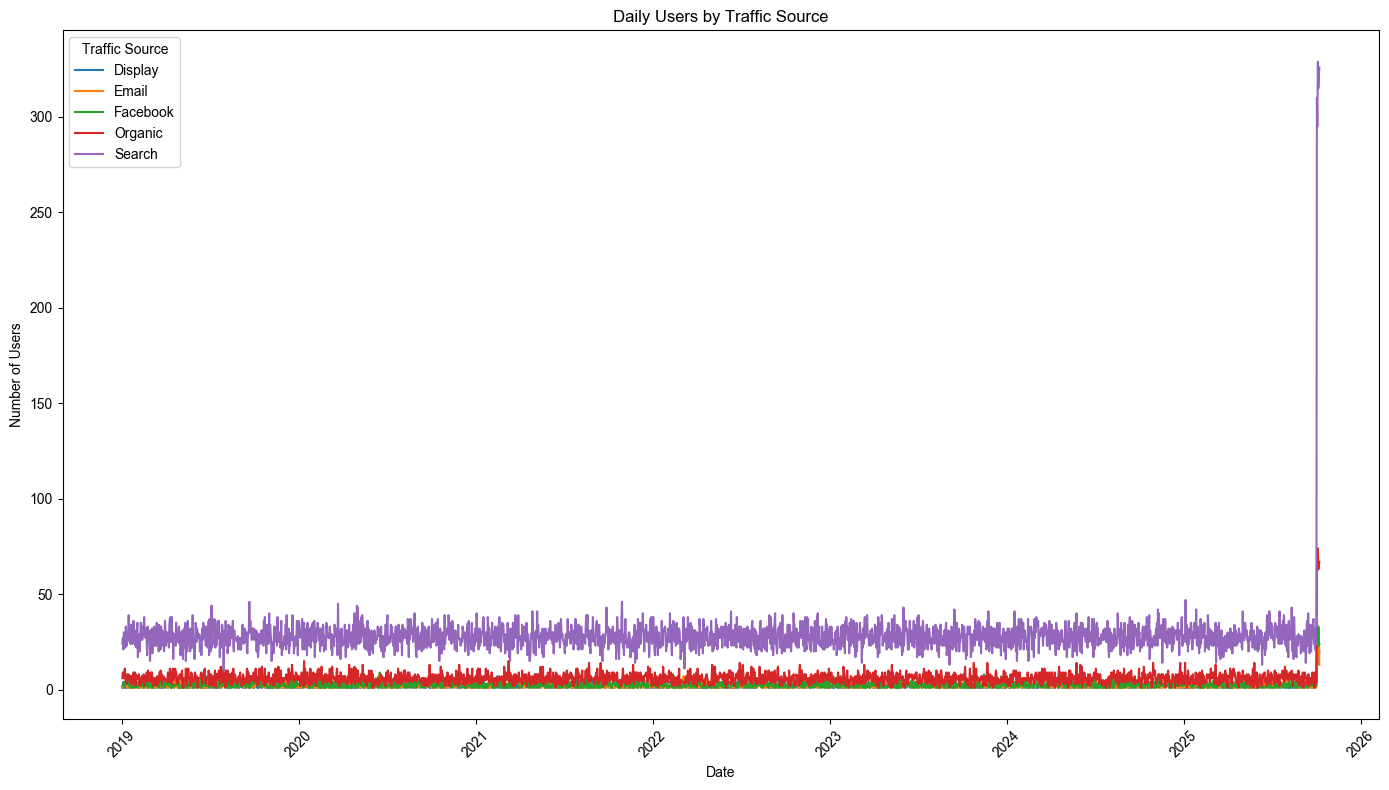

In [72]:
daily_traffic = users_df.groupby(['date','traffic_source']).agg(usr_cnt= ('id','count')).reset_index()
plt.figure(figsize=(14,8))
sns.lineplot(data=daily_traffic, x='date', y='usr_cnt', hue='traffic_source')
plt.xticks(rotation=45)
plt.title("Daily Users by Traffic Source")
plt.xlabel("Date")
plt.ylabel("Number of Users")
plt.legend(title="Traffic Source")
plt.tight_layout()
plt.show()